In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
# There is a package called PrettyTensor
import prettytensor as pt
import matplotlib as mpl
import math

In [4]:
import sys
sys.path.append('../')

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('../data/MNIST/',one_hot=True)

Extracting ../data/MNIST/train-images-idx3-ubyte.gz
Extracting ../data/MNIST/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST/t10k-labels-idx1-ubyte.gz


In [9]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Testing-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Testing-set:		10000
- Validation-set:	5000


In [10]:
img_size = 28
img_size_flat = img_size**2
img_shape = (img_size, img_size)
num_channels = 1
num_classes = 10

In [14]:
mpl.rc('font',family='Times New Roman',size = 12)
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 2

###### Helper function for plotting images

In [21]:
def plot_images(images, cls_true, cls_pred = None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3X3 sub plots
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace = 0.5, wspace = 0.3)
    for i,ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(img_shape),cmap = 'binary')
        #show true and predicted classes
        if cls_pred is None:
            x_label = "True: {0}".format(cls_true[i])
        else:
            x_label = "True: {0}, Pred: {1}".format(cls_true[i],cls_pred[i])
        ax.set_xlabel(x_label)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

###### Plot a few images from the test set:

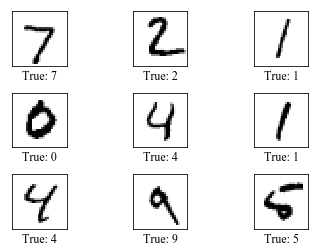

In [22]:
images = data.test.images[0:9]
data.test.cls = np.argmax(data.test.labels, axis = 1)
cls_true = data.test.cls[0:9]
plot_images(images, cls_true)

###### Input of the tensorflow graph:

In [23]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name = 'x')

In [24]:
y_true = tf.placeholder(tf.float32, shape=[None, 10], name = 'y_true')

In [25]:
y_true_cls = tf.argmax(y_true, axis = 1)

In [26]:
x_img = tf.reshape(x, [-1,img_size,img_size,num_channels])

In [27]:
x_pretty = pt.wrap(x_img)

In [31]:
with pt.defaults_scope(activation_fn = tf.nn.relu):
    y_pred, loss = x_pretty.\
    conv2d(kernel=5, depth=16, name='layer_conv1').\
    max_pool(kernel=2, stride=2).\
    conv2d(kernel=5, depth=36, name='layer_conv2').\
    max_pool(kernel=2, stride=2).\
    flatten().\
    fully_connected(size=128, name='layer_fc1').\
    softmax_classifier(num_classes=10, labels=y_true)

###### Need to call some tensorflow functions to get weights

In [32]:
def get_weights_variable(layer_name):
    with tf.variable_scope(layer_name, reuse=True):
        variable = tf.get_variable('weights')
    return variable

In [33]:
weights_conv1 = get_weights_variable(layer_name='layer_conv1')
weights_conv2 = get_weights_variable(layer_name='layer_conv2')

###### Optimizer The same

In [34]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

In [37]:
y_pred_cls = tf.argmax(y_pred, axis=1)

In [38]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [39]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [40]:
session = tf.Session()

In [41]:
session.run(tf.global_variables_initializer())

In [42]:
train_batch_size = 64

In [43]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [44]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [45]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [46]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [47]:
print_test_accuracy()

Accuracy on Test-Set: 7.7% (774 / 10000)


In [48]:
optimize(num_iterations=1)

Optimization Iteration:      1, Training Accuracy:   9.4%
Time usage: 0:00:01


In [49]:
print_test_accuracy()

Accuracy on Test-Set: 8.7% (873 / 10000)


In [50]:
optimize(num_iterations=99) # We already performed 1 iteration above.

Time usage: 0:00:11


Accuracy on Test-Set: 88.3% (8827 / 10000)
Example errors:


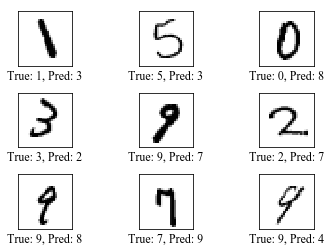

In [51]:
print_test_accuracy(show_example_errors=True)

In [52]:
optimize(num_iterations=900) # We performed 100 iterations above.

Optimization Iteration:    101, Training Accuracy:  82.8%
Optimization Iteration:    201, Training Accuracy:  90.6%
Optimization Iteration:    301, Training Accuracy:  90.6%
Optimization Iteration:    401, Training Accuracy:  98.4%
Optimization Iteration:    501, Training Accuracy:  92.2%
Optimization Iteration:    601, Training Accuracy:  96.9%
Optimization Iteration:    701, Training Accuracy:  93.8%
Optimization Iteration:    801, Training Accuracy:  93.8%
Optimization Iteration:    901, Training Accuracy:  96.9%
Time usage: 0:01:29


Accuracy on Test-Set: 97.0% (9695 / 10000)
Example errors:


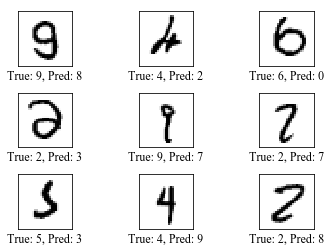

In [53]:
print_test_accuracy(show_example_errors=True)

Optimization Iteration:   1001, Training Accuracy:  98.4%
Optimization Iteration:   1101, Training Accuracy:  96.9%
Optimization Iteration:   1201, Training Accuracy:  95.3%
Optimization Iteration:   1301, Training Accuracy:  95.3%
Optimization Iteration:   1401, Training Accuracy: 100.0%
Optimization Iteration:   1501, Training Accuracy:  96.9%
Optimization Iteration:   1601, Training Accuracy:  98.4%
Optimization Iteration:   1701, Training Accuracy:  95.3%
Optimization Iteration:   1801, Training Accuracy: 100.0%
Optimization Iteration:   1901, Training Accuracy:  98.4%
Optimization Iteration:   2001, Training Accuracy:  96.9%
Optimization Iteration:   2101, Training Accuracy: 100.0%
Optimization Iteration:   2201, Training Accuracy:  96.9%
Optimization Iteration:   2301, Training Accuracy:  95.3%
Optimization Iteration:   2401, Training Accuracy:  96.9%
Optimization Iteration:   2501, Training Accuracy: 100.0%
Optimization Iteration:   2601, Training Accuracy:  96.9%
Optimization I

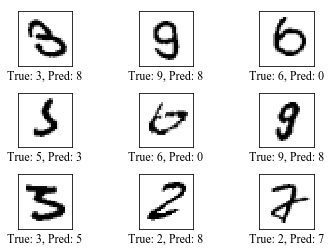

Confusion Matrix:
[[ 973    0    0    0    0    1    2    1    3    0]
 [   0 1132    1    0    0    0    1    0    1    0]
 [   1    3 1008    1    1    0    0    4   14    0]
 [   0    0    1 1000    0    3    0    0    5    1]
 [   0    0    0    0  979    0    1    0    1    1]
 [   2    0    0    5    1  879    2    1    1    1]
 [   5    2    0    0    1    2  945    0    3    0]
 [   0    1    2    2    0    0    0 1020    1    2]
 [   2    0    0    0    0    1    0    1  969    1]
 [   1    4    0    0   13    3    1    4    8  975]]


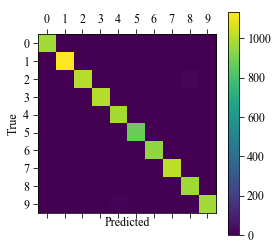

In [54]:
optimize(num_iterations=9000) # We performed 1000 iterations above.
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

##### Plot weights

In [55]:
def plot_conv_weights(weights, input_channel=0):
    # Assume weights are TensorFlow ops for 4-dim variables
    # e.g. weights_conv1 or weights_conv2.
    
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = session.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Number of filters used in the conv. layer.
    num_filters = w.shape[3]

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot all the filter-weights.
    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i<num_filters:
            # Get the weights for the i'th filter of the input channel.
            # See new_conv_layer() for details on the format
            # of this 4-dim tensor.
            img = w[:, :, input_channel, i]

            # Plot image.
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

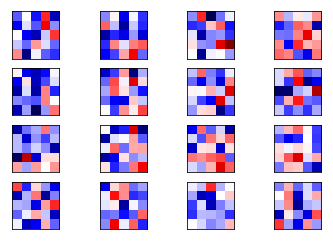

In [58]:
plot_conv_weights(weights=weights_conv1)

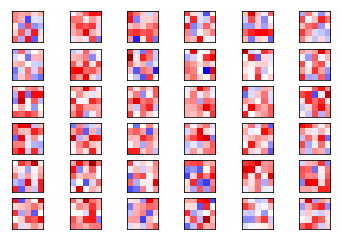

In [59]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

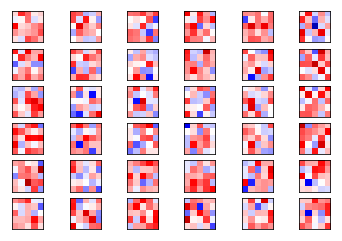

In [60]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

In [61]:
session.close()